# Wetland water depth visualisation <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook and saved out a netCDF file containing all the variables at the end of the notebook.

## Background
The Commonwealth Environmental Water Office (CEWO) is obliged to act in accordance with the Water Act and the Basin Plan.  This requires Basin water resources to be managed in a way that gives effect to relevant international agreements (to the extent to which those agreements are relevant to the use and management of the Basin water resources). The Basin Plan has a specific objective to protect and restore a subset of all water-dependent ecosystems of the Murray-Darling Bain including by ensuring that: 
* Declared Ramsar wetlands that depend on Basin water resources maintain their ecological character. 

## Description
This notebook produces the following deliverables for each Ramsar site for each 10 year time period: 

* Maps in the form of .jpg, polygons and rasters showing: (these maps should also include key vegetation types, including open water, as provided by the CEWO and also the Ramsar site boundary.)
    * Inundation extent for each month across the time period. (This could be presented so that you can slide along a hydrograph and see the resultant inundation extent on a map below. This should also identify key vegetation types. 
    * Inundation extent for each vegetation type for each event (an event comprises the time between commencement of inundation of the vegetation type and conclusion of inundation of the vegetation type i.e. vegetation type completely dry) across the period event for critical durations (1, 3, 5, 7, >9 months)(these inundation extents are critical for different types of vegetation) 
        * Derived from remote sensing <img align='right' src="./InputData/TOR-AttachmentA.png" style="width: 400px;"/>
        * Comparison of remotely sensed data with ground-truthed data and OEH datasets (NSW only). 
    * Maps of depth for critical durations, only if DEM data is available within GA or supplied by CEWO (1, 3, 5, 7, >9 months)  
    * Vegetation condition over the entire four year period. 
* Graph and .csv file of inundation duration for each different vegetation type, for all natural and environmental flows, as per image to the right
* Table identifying: 
    * % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation.
    * Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type 
e.g. 

| Site | Sub-site | Decade | Vegetation Type | % inundated 1 month | % inundated 3 months | % inundated 5 months | % inundated 7 months | % inundated > 9 months | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|
|Banrock Station | | |River redgum | | | | | | |
| | | |Black box | | | | | | |
| | | |Lignum| | | | | | |
| | | |Saltmarsh| | | | | | |
| | | |Tall emergent aquatics| | | | | | |
| | | |Grass/forb | | | | | | |


* Annual vegetation condition for each Ramsar site for the whole archive period
***

## (Progress tracking)

| Wetland | LiDAR DEM | Vegetation shapefile | NetCDF created? | 
|---------|-----------|----------------------|-----------------|
| Narran Lake | <ul><li>Data are a combination of [GA's aggregated 5m DEM product](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/89644), and NSW Spatial Services 5m DEM scenes from the couple of bits of the eastern edge of the Ramsar polygon that are cut out of the GA product</li><li>The combination happened by clipping the GA and required additional NSW scenes to the extent of the Ramsar polygon.</li><li> These were then merged together using the `mosaic` tool in ArcGIS, where the GA scene was given preference over the NSW scenes where data existed in both</li></ul>  | `VegShapeFileVegNameColumn = 'AggCOMM'` `VegShapeFileVegNameUIDColumn = None` | Yes |


## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import xarray as xr
import numpy as np
import pandas as pd
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape

### Analysis parameters

* `AnalysisLocation`: A string descriptor of the analysis region used to label graphs.

#### Files to analyse
* `DatasetToLoad` : The filename of the netCDF written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) to read in here. Note that this file must have been written out by the first notebook, as we assume the variables created in that notebook exist here. If you try to read in something else, this code will fail.
* `SpeciesDictToLoad` : The filename of the text file written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) that contains the species dictionary of vegetation type and numerical ID. This is used to label plots.

#### Analysis options
* `Decades` : e.g. `{'1990s':('1990-01-01', '1999-12-31'), '2000s':('2000-01-01', '2009-12-31'), '2010s':('2010-01-01', '2019-12-31')}`. A dictionary of decades over which to analyse some of our results. If you want this to be a different time period other than decades, just change that here and include an appropriate descriptive dictionary key for each time period. 
* `PercentilesToCalc`: e.g. `['1', '25', '50', '75', '99']`. In the code below we do some analysis using percentiles. Include the percentiles you want to calculate as a list of strings here. We turn them into integers below to do the calculation, but use these strings for labelling.

In [23]:
# Note, if your `AnalysisLocation` contains special characters other than spaces, you will
# need to modify the `replace` function used to generate the output file names.
AnalysisLocation = 'Narran Lake'

DatasetToLoad = f'OutputData/AllDataCombined{AnalysisLocation.replace(" ", "")}.nc'
SpeciesDictToLoad = f'OutputData/SpeciesDict{AnalysisLocation.replace(" ", "")}.txt'

EventThreshold = 5
Decades = {'1990s':('1990-01-01', '1999-12-31'), '2000s':('2000-01-01', '2009-12-31'), '2010s':('2010-01-01', '2019-12-31')}
PercentilesToCalc = ['1', '5', '10', '25', '50', '75', '99']

EventListFileName = f'OutputData/WetEventsIn{AnalysisLocation.replace(" ", "")}With{str(EventThreshold)}%AreaThreshold.txt'
EventInundationTableFileName = f'OutputData/EventInundationMetricsFor{AnalysisLocation.replace(" ", "")}.txt'

InundationPctPerVegFigFileName = f'OutputData/InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.jpg'
InundationPctPerVegDataFileName = f'OutputData/InundationPctPerVeg{AnalysisLocation.replace(" ", "")}.txt'

## Load in our pre-analysed datasets

In [3]:
AllDataCombined = xr.open_dataset(DatasetToLoad)

We also need to load in the species dictionary we saved out

In [4]:
with open(SpeciesDictToLoad, 'r') as f: 
    content = f.read()
    SpeciesDict = eval(content)

We need to regenerate the order of vegetation communities by mean HAND, and then match up that order with the `SpeciesDict` to get the tick labels.

In [5]:
# Now recalculate our median HAND values and sort the data based on this
MedianHAND = AllDataCombined.HAND.groupby(AllDataCombined['veg_randomUID']).median()
myorder = MedianHAND.sortby(MedianHAND)['veg_randomUID'].values

In [6]:
# Grab the correct vegetation labels in the right order
XTickNames = []
for vegvalue in myorder:
    VegName = SpeciesDict[int(vegvalue)]
    # Check how long the veg name is and if it's longer than 20 char, shorten.
    if len(VegName) > 20:
        XTickNames.append(VegName[:20])
    else:
        XTickNames.append(VegName)

In [7]:
AllDataCombined.attrs

{'crs': '+proj=aea +lat_0=0 +lon_0=132 +lat_1=-18 +lat_2=-36 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs',
 'grid_mapping': 'spatial_ref'}

## Break up the vegetation data into discrete communities

While we can subset our area of interest according to vegetation type, there is likely to be a spatial component to the inundation characteristics of different sub communities within a vegetation class. 

We therefore polygonise the vegetation data (you could just read in the original polygon shapefile, but since the data are already here and mapped to Landsat pixels, we'll polygonise the raster), and remove any very small vegetation communites (smaller than 10 landsat pixels). These different polygons will allow us to explore the spatial heterogeneities in the vegetation wetness characteristics. 

In [8]:
VegPolygons = features.shapes(AllDataCombined['veg_randomUID'].data.astype('float32'),
                              transform=AllDataCombined.geobox.transform)

PolygonGP = gpd.GeoDataFrame(VegPolygons, columns =['stringgeom', 'vegUID'])

PolygonGP['geometry'] = None
for ix, poly in PolygonGP.iterrows():
    PolygonGP.loc[ix,'geometry'] = shape(poly[0])
    
# Set the geometry of the dataframe to be the shapely geometry we just created
PolygonGP = PolygonGP.set_geometry('geometry')
# We need to add the crs back onto the dataframe
PolygonGP.crs = 'EPSG:3577'

# Drop the nan polygon created from the nan values
PolygonGP = PolygonGP.loc[~np.isnan(PolygonGP['vegUID'])]

# And drop the stringgeom
PolygonGP.drop('stringgeom', axis=1, inplace=True)

AttributeError: 'Dataset' object has no attribute 'geobox'

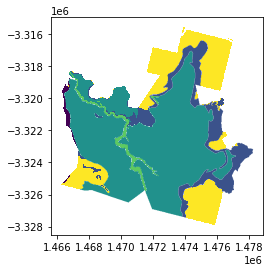

In [200]:
PolygonGP.plot(column='vegUID');

### Drop small vegetation polygons

We want to limit the number of small polygons in the analysis, so we calculate the area of each polygon and drop polygons smaller than 10 Landsat pixels `(25 * 25 * 10) = 6250`. 

In [175]:
PolygonGP['area'] = PolygonGP['geometry'].area

In [194]:
# Drop small polygons
print(f'Number of original polygons = {len(PolygonGP)}')
PolygonGPfiltered = PolygonGP.loc[PolygonGP['area'] >= 6250].reset_index()
print(f'Number of filtered polygons = {len(PolygonGPfiltered)}')

Number of original polygons = 96
Number of filtered polygons = 47


## 1. Maps of inundation extent across the time period 2014-2019

**to start, annual max inundation for 2014-2020**

Inundation extent for each month across the time period. (This could be presented so that you can slide along a hydrograph and see the resultant inundation extent on a map below. This should also identify key vegetation types). These maps should also include key vegetation types, including open water

## 2. Maps of inundation extent for each vegetation type for each event 

An event comprises the time between commencement of inundation of the vegetation type and conclusion of inundation of the vegetation type i.e. vegetation type completely dry. Sort by events for critical durations: 1, 3, 5, 7, > 9 months.

### 2.a. Comparison of remotely sensed data maps with ground-truthed data and OEH datasets 

(NSW only)

## 3. Maps of depth for critical durations

Only if DEM data is available within GA or supplied by CEWO (1, 3, 5, 7, >9 months)

## 4. Vegetation condition over the entire four year period

## 5. Graph and .csv file of inundation duration for each different vegetation type
For all natural and environmental flows

In [9]:
# Create a dataframe to put our results into, starting with the time
InundationPctPerVeg = pd.DataFrame({'Date': AllDataCombined.time})
# Make the time the index for the dataframe
InundationPctPerVeg.set_index('Date', inplace=True)

# Loop through all the vegetation communities
for items in SpeciesDict:
    # Grab just the pixels containing our veg community
    WetVeg = AllDataCombined['wetCount'].where(AllDataCombined['veg_randomUID'] == items)
    # Count the number of wet observations per time step
    WetVegCount = WetVeg.sum(dim=['x', 'y'])
    # Convert the count to a percentage of the total community that's wet
    WetVegPct = (WetVegCount / (AllDataCombined['veg_randomUID'] == items).sum()) * 100
    InundationPctPerVeg[SpeciesDict[items]] = WetVegPct

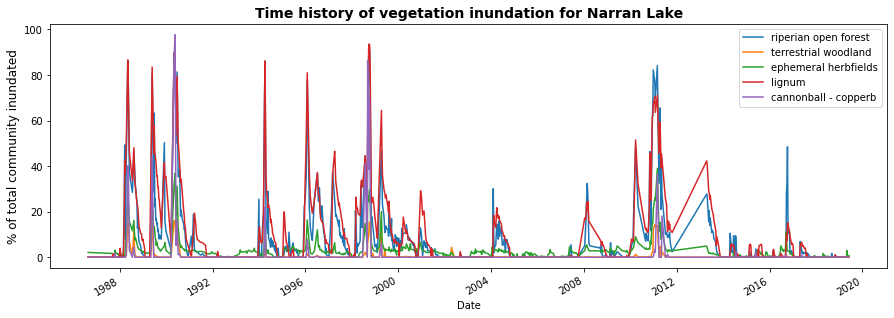

In [10]:
InundationPctPerVeg.plot(figsize=[15,5]);
plt.ylabel(f'% of total community inundated', fontsize = 12);
plt.title(f'Time history of vegetation inundation for {AnalysisLocation}', fontsize = 14, fontweight = 'bold');
plt.savefig(InundationPctPerVegFigFileName, bbox_inches='tight')

### Save out the data as a csv file

In [13]:
InundationPctPerVeg.to_csv(InundationPctPerVegDataFileName)

## 6. Table identifying: 
* % of different vegetation classes inundated for each specified time period for each event and maximum and average depth of inundation.
* Time between each inundation event for 10%, 25%, 50%, 75% and 100% of each vegetation type 
e.g. 

| Site | Sub-site | Decade | Vegetation Type | % inundated 1 month | % inundated 3 months | % inundated 5 months | % inundated 7 months | % inundated > 9 months | Max depth | Average depth |
|-----|----|----|----|----|----|----|----|----|----|----|

### Identify 'events' within the wetland

Here an 'event' starts when 5% of the total wetland area seen as wet, and ends when no more than 5% of the wetland remains 'wet'. 

In [11]:
# Count the wet pixels per time step, and find where at least 5% of the wetland is 'wet'
AnyPartWet = AllDataCombined['wetCount'].sum(dim=['x', 'y']) > ((len(AllDataCombined.x) * len(AllDataCombined.y)) / 100 * EventThreshold)

Find where the wetland switches above/below 5% inundation. We can do this by looking for changes in the boolean operators

In [12]:
# Subtract subsequent value from first value
Testforchange = AnyPartWet[1:].values.astype(int) - AnyPartWet[:-1].values.astype(int)
# if it equals 1, then the array has moved from False to True
StartofEvent = AnyPartWet[1:].where(Testforchange == 1).dropna(dim='time')
# if it equals -1, then the array has moved from True to False
EndofEvent = AnyPartWet[1:].where(Testforchange == -1).dropna(dim='time')

Make use of pandas datetime operators to calculate the length of time between each start and end date. 

*TO DO: this is not yet coded for times when we have a final start date but no end date i.e. the event hasn't been observed to end yet.*

In [13]:
# We need to check whether the wetland is first observed during a wet event. 
# If it is, then the first value we actually find is an end date, which throws off our calculation.
# Code notation notes:
#`astype('timedelta64[D]')` converts the timedelta from `ns` to `days`. 
#`/ np.timedelta64(1, 'D')` removes the timedelta information and just returns the number of days as a float.
if (EndofEvent.time.values[0] - StartofEvent.time.values[0]).astype('timedelta64[D]') / np.timedelta64(1, 'D') < 0:
    # Skip the first EndofEvent, since we didn't capture the start
    EventDuration = (EndofEvent.time.values[1:] - StartofEvent.time.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')
else:
    EventDuration = (EndofEvent.time.values - StartofEvent.time.values).astype('timedelta64[D]') / np.timedelta64(1, 'D')

Convert the results into a dataframe so we can export to csv

In [14]:
EventList = pd.DataFrame(EventDuration.astype(int),  
                         columns = ['days-in-event'])
EventList['event-start-date'] = StartofEvent.time.dt.strftime('%Y-%m-%d').values.astype(str)
EventList['event-end-date'] = EndofEvent.time.dt.strftime('%Y-%m-%d').values.astype(str)

EventList.to_csv(EventListFileName)

### We need to set up a dataframe to put the results into

In [15]:
# Create a dataframe to put our results into, starting with the time
EventInundationTable = pd.concat([EventList]*len(SpeciesDict)).sort_values(by='event-start-date', ignore_index=True)
EventInundationTable['vegType'] = list(SpeciesDict.values())* len(EventList)
EventInundationTable['PctInundated>=30days'] = np.nan
EventInundationTable['PctInundated>=90days'] = np.nan
EventInundationTable['PctInundated>=150days'] = np.nan
EventInundationTable['PctInundated>=210days'] = np.nan
EventInundationTable['PctInundated>=270days'] = np.nan

In [16]:
EventInundationTable.head(6)

,days-in-event,event-start-date,event-end-date,vegType,PctInundated>=30days,PctInundated>=90days,PctInundated>=150days,PctInundated>=210days,PctInundated>=270days
0,231,1988-03-10,1988-10-27,riperian open forest,NaN,NaN,NaN,NaN,NaN
1,231,1988-03-10,1988-10-27,terrestrial woodland,NaN,NaN,NaN,NaN,NaN
2,231,1988-03-10,1988-10-27,ephemeral herbfields,NaN,NaN,NaN,NaN,NaN
3,231,1988-03-10,1988-10-27,lignum,NaN,NaN,NaN,NaN,NaN
4,231,1988-03-10,1988-10-27,cannonball - copperb,NaN,NaN,NaN,NaN,NaN
5,167,1989-04-30,1989-10-14,riperian open forest,NaN,NaN,NaN,NaN,NaN


### Now calculate the % inundation of each vegetation category per event

Here, the analysis is done on a per event basis. This means that we assume that if a single pixels wets, dries, wets etc more than once, it's all related to the same wetland-wide event (which is defined above). 

The code below loops through each species type within the wetland, and calculates the percentage of that species' area that is inundated for more than 30, 90, 150, 210 and 270 days during the whole event. If a single pixel records a wetting history of e.g. 5 days wet, then is dry for 5 days, then wet for 45 days, then we consider this pixel to have been wet for 50 days during this event. 

Metrics for wet percentage for the 30, 90, 150, 210 and 270 day periods are calculated using >= each period. For example, a pixel that was wet for 110 days during an event will be counted in the 30 and 90 day metrics, but not the 150 day metric. 

In [17]:
# Make an empty array to put the event results in to
EventResults = np.empty((len(AllDataCombined.y), len(AllDataCombined.x)))
EventResults[:] = np.nan

# Loop through all the vegetation communities
for items in SpeciesDict:
    # Loop through all the individual wetting events
    for ix, row in EventList.iterrows():
        # Grab just the wet pixels that intersect with our veg type (boolean)
        JustOneVegTypeWet = AllDataCombined['wetCount'].where(AllDataCombined['veg_randomUID'] == items)
        # Grab just the time slices that coincide with the event we're now analysing
        EventData = JustOneVegTypeWet.loc[slice(row['event-start-date'], row['event-end-date'])]
        # Now loop through each pixel and work out how long it was inundated for during the event
        for x in range(len(EventData.x)):
            for y in range(len(EventData.y)):
                pixelArray=EventData[:,y,x]
                # test whether this pixel is just all NaN - if it is, we don't need to analyse it
                if pixelArray.sum() > 0:
                    # Subtract subsequent value from first value
                    Testforchange = pixelArray[1:].values.astype(int) - pixelArray[:-1].values.astype(int)
                    # if it equals 1, then the array has moved from False to True
                    StartofEvent = pixelArray[:-1].where(Testforchange == 1).dropna(dim='time')
                    # if it equals -1, then the array has moved from True to False
                    EndofEvent = pixelArray[1:].where(Testforchange == -1).dropna(dim='time')
                    # We need to check whether we've captured the start of the event properly
                    # If the event starts as wet at time zero, we wont capture this in the code below
                    # Because we know that time 0 of this event is the start of the wetland-wide event,
                    # we can just add time 0 as the first start date.
                    if pixelArray[0] == 1:
                        # Grab the first time step of the event and add it to the StartofEvent array
                        StartofEvent = np.hstack((pixelArray.time.values[0], StartofEvent.time.values))
                    else:
                        # If not, just change the format of the StartofEvent variable to match the changed one
                        StartofEvent = StartofEvent.time.values
                    # Also need to check if we've captured the end of the event properly
                    # If the event ends with a wet observation, we wont capture this in the code below
                    # Because we know that time -1 of this event is the end of the wetland-wide event,
                    # we can just add time -1 as the last end date.
                    if pixelArray[-1] == 1:
                        # Then the event wont 'end' since it wont have flipped
                        EndofEvent = np.hstack((pixelArray.time.values[-1], EndofEvent.time.values))
                    else:
                        # If not, just change the format of the EndofEvent variable to match the changed one
                        EndofEvent = EndofEvent.time.values
                    # Now calculate the length of time between the inundation events within the overall wetland event
                    EventDuration = (EndofEvent - StartofEvent).astype('timedelta64[D]') / np.timedelta64(1, 'D')
                    # Sum the total inundation time
                    EventResults[y,x] = EventDuration.sum()
    # Now sum up the number of pixels inundated for each time period
    # Get the index of the row we need to put the results into
    indexofrow = EventInundationTable.loc[(EventInundationTable['event-start-date'] == row['event-start-date']) 
                         & (EventInundationTable['vegType'] == SpeciesDict[items])].index.item()
    # Calculate the percent of each vegetation community inundated for the various lengths of time
    EventInundationTable.at[indexofrow,'PctInundated>=30days'] = ((EventResults >=30).sum() / 
                                                                  (AllDataCombined['veg_randomUID'] == items).sum().item()) * 100
    EventInundationTable.at[indexofrow,'PctInundated>=90days'] = ((EventResults >=90).sum() / 
                                                                  (AllDataCombined['veg_randomUID'] == items).sum().item()) * 100
    EventInundationTable.at[indexofrow,'PctInundated>=150days'] = ((EventResults >=150).sum() / 
                                                                   (AllDataCombined['veg_randomUID'] == items).sum().item()) * 100
    EventInundationTable.at[indexofrow,'PctInundated>=210days'] = ((EventResults >=210).sum() / 
                                                                   (AllDataCombined['veg_randomUID'] == items).sum().item()) * 100
    EventInundationTable.at[indexofrow,'PctInundated>=270days'] = ((EventResults >=270).sum() / 
                                                                   (AllDataCombined['veg_randomUID'] == items).sum().item()) * 100

/env/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater_equal
/env/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater_equal
/env/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater_equal
/env/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/env/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater_equal


KeyboardInterrupt: 

In [30]:
EventInundationTable.head(6)

,days-in-event,event-start-date,event-end-date,vegType,PctInundated>=30days,PctInundated>=90days,PctInundated>=150days,PctInundated>=210days,PctInundated>=270days
0,231,1988-03-10,1988-10-27,riperian open forest,NaN,NaN,NaN,NaN,NaN
1,231,1988-03-10,1988-10-27,terrestrial woodland,NaN,NaN,NaN,NaN,NaN
2,231,1988-03-10,1988-10-27,ephemeral herbfields,NaN,NaN,NaN,NaN,NaN
3,231,1988-03-10,1988-10-27,lignum,NaN,NaN,NaN,NaN,NaN
4,231,1988-03-10,1988-10-27,cannonball - copperb,NaN,NaN,NaN,NaN,NaN
5,167,1989-04-30,1989-10-14,riperian open forest,NaN,NaN,NaN,NaN,NaN


In [24]:
EventInundationTable.to_csv(EventInundationTableFileName)

## 7. Annual vegetation condition for each Ramsar site for the whole archive period